In [1]:
from collections import Counter
import random
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd

from data_manipulation.reading_util import load_all_sub_classes, load_ml_data_emb
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import os
from dotenv import load_dotenv
from data_manipulation.reading_util import load_non_enz_esm2
from metrics_helper_funcs.validation_tools import plot_bootstrapped_score, plot_confiusion_matrix, calculate_micro_f1, calculate_accuracy, calculate_macro_f1, calculate_weighted_f1, calculate_macro_recall, calculate_macro_precision, calculate_mcc_score, bootstrap_statistic, round_to_significance

load_dotenv()



2024-01-08 17:02:03.178033: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 17:02:04.260687: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


True

In [2]:
comp_ec_to_label = {
    "1.1": 0,
    "1.2": 1,
    "1.3": 2,
    "1.4": 3,
    "1.5": 4,
    "1.6": 5,
    "1.7": 6,
    "1.8": 7,
    "1.11": 8,
    "1.12": 9,
    "1.13": 10,
    "1.14": 11,
    "1.15": 12,
    "1.16": 13,
    "1.17": 14,
    "1.18": 15,
    "1.21": 16,
    "1.10": 17,
    "1.20": 17,
    "1.23": 17,
    "1.97": 17,
    "2.1": 18,
    "2.3": 19,
    "2.4": 20,
    "2.5": 21,
    "2.6": 22,
    "2.7": 23,
    "2.8": 24,
    "2.2": 25,
    "2.9": 25,
    "2.10": 25,
    "3.1": 26,
    "3.2": 27,
    "3.4": 28,
    "3.5": 29,
    "3.6": 30,
    "3.3": 31,
    "3.7": 31,
    "3.8": 31,
    "3.9": 31,
    "3.11": 31,
    "3.13": 31,
    "4.1": 32,
    "4.2": 33,
    "4.3": 34,
    "4.4": 35,
    "4.6": 36,
    "4.99": 37,
    "4.7": 37,
    "4.5": 37,
    "5.1": 38,
    "5.2": 39,
    "5.3": 40,
    "5.4": 41,
    "5.5": 42,
    "5.6": 43,
    "5.7": 43,
    "5.99": 43,
    "6.1": 44,
    "6.2": 45,
    "6.3": 46,
    "6.5": 47,
    "6.4": 47,
    "6.6": 47,
    "7.1": 48,
    "7.2": 49,
    "7.3": 50,
    "7.4": 50,
    "7.5": 50,
    "7.6": 50,
}

comp_label_to_ec = {
    0: "1.1" ,
    1: "1.2" ,
    2: "1.3" ,
    3: "1.4" ,
    4: "1.5" ,
    5: "1.6" ,
    6: "1.7" ,
    7: "1.8" ,
    8: "1.11" ,
    9: "1.12" ,
    10: "1.13" ,
    11: "1.14" ,
    12: "1.15" ,
    13: "1.16" ,
    14: "1.17" ,
    15: "1.18" ,
    16: "1.21" ,
    17: "1.10_20_23_97" ,
    18: "2.1" ,
    19: "2.3" ,
    20: "2.4" ,
    21: "2.5" ,
    22: "2.6" ,
    23: "2.7" ,
    24: "2.8" ,
    25: "2.2_9_19" ,
    26: "3.1" ,
    27: "3.2" ,
    28: "3.4" ,
    29: "3.5" ,
    30: "3.6" ,
    31: "3.3_7_8_9_11_13" ,
    32: "4.1" ,
    33: "4.2" ,
    34: "4.3" ,
    35: "4.4" ,
    36: "4.6" ,
    37: "4.99_7_5" ,
    38: "5.1" ,
    39: "5.2" ,
    40: "5.3" ,
    41: "5.4" ,
    42: "5.5" ,
    43: "5.6_7_99" ,
    44: "6.1" ,
    45: "6.2" ,
    46: "6.3" ,
    47: "6.5_4_6" ,
    48: "7.1" ,
    49: "7.2" ,
    50: "7.3_4_5_6" ,
}



comp_ec_to_label_non_ez = {
    "1.1": 0,
    "1.2": 1,
    "1.3": 2,
    "1.4": 3,
    "1.5": 4,
    "1.6": 5,
    "1.7": 6,
    "1.8": 7,
    "1.11": 8,
    "1.12": 9,
    "1.13": 10,
    "1.14": 11,
    "1.15": 12,
    "1.16": 13,
    "1.17": 14,
    "1.18": 15,
    "1.21": 16,
    "1.10": 17,
    "1.20": 17,
    "1.23": 17,
    "1.97": 17,
    "2.1": 18,
    "2.3": 19,
    "2.4": 20,
    "2.5": 21,
    "2.6": 22,
    "2.7": 23,
    "2.8": 24,
    "2.2": 25,
    "2.9": 25,
    "2.10": 25,
    "3.1": 26,
    "3.2": 27,
    "3.4": 28,
    "3.5": 29,
    "3.6": 30,
    "3.3": 31,
    "3.7": 31,
    "3.8": 31,
    "3.9": 31,
    "3.11": 31,
    "3.13": 31,
    "4.1": 32,
    "4.2": 33,
    "4.3": 34,
    "4.4": 35,
    "4.6": 36,
    "4.99": 37,
    "4.7": 37,
    "4.5": 37,
    "5.1": 38,
    "5.2": 39,
    "5.3": 40,
    "5.4": 41,
    "5.5": 42,
    "5.6": 43,
    "5.7": 43,
    "5.99": 43,
    "6.1": 44,
    "6.2": 45,
    "6.3": 46,
    "6.5": 47,
    "6.4": 47,
    "6.6": 47,
    "7.1": 48,
    "7.2": 49,
    "7.3": 50,
    "7.4": 50,
    "7.5": 50,
    "7.6": 50,
    "Non enzyme":51
}


comp_label_to_ec_non_ez = {
    0: "1.1" ,
    1: "1.2" ,
    2: "1.3" ,
    3: "1.4" ,
    4: "1.5" ,
    5: "1.6" ,
    6: "1.7" ,
    7: "1.8" ,
    8: "1.11" ,
    9: "1.12" ,
    10: "1.13" ,
    11: "1.14" ,
    12: "1.15" ,
    13: "1.16" ,
    14: "1.17" ,
    15: "1.18" ,
    16: "1.21" ,
    17: "1.10|20|23|97" ,
    18: "2.1" ,
    19: "2.3" ,
    20: "2.4" ,
    21: "2.5" ,
    22: "2.6" ,
    23: "2.7" ,
    24: "2.8" ,
    25: "2.2|9|19" ,
    26: "3.1" ,
    27: "3.2" ,
    28: "3.4" ,
    29: "3.5" ,
    30: "3.6" ,
    31: "3.3|7|8|9|11|13" ,
    32: "4.1" ,
    33: "4.2" ,
    34: "4.3" ,
    35: "4.4" ,
    36: "4.6" ,
    37: "4.99|7|5" ,
    38: "5.1" ,
    39: "5.2" ,
    40: "5.3" ,
    41: "5.4" ,
    42: "5.5" ,
    43: "5.6|7|99" ,
    44: "6.1" ,
    45: "6.2" ,
    46: "6.3" ,
    47: "6.5|4|6" ,
    48: "7.1" ,
    49: "7.2" ,
    50: "7.3|4|5|6" ,
    51: "Non enzyme"
}




In [3]:
print(len(comp_ec_to_label_non_ez))

71


In [4]:
# Random level 0 pred
def random_level_0(y):
    file_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/only_enzyme_models/y_train_level_0_lables.txt"
    with open(file_path, 'r') as file:
        y_train = np.array([int(line.strip()) for line in file])

        count_dict = Counter(y_train)
        predictions = [random.choices(list(count_dict.keys()), weights=count_dict.values())[0] for _ in y]
        return np.array(predictions)


In [5]:
# Random level 1 pred
def random_level_1(y):
    file_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/only_enzyme_models/y_train_level_1_lables.txt"
    with open(file_path, 'r') as file:
        y_train = np.array([int(line.strip()) for line in file])

        count_dict = Counter(y_train)
        predictions = [random.choices(list(count_dict.keys()), weights=count_dict.values())[0] for _ in y]
        return np.array(predictions)


In [6]:
# Random level 2 pred
def random_level_2(y):
    file_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/y_train_subclass_lables.txt"
    with open(file_path, 'r') as file:
        y_train = np.array([int(line.strip()) for line in file])

        count_dict = Counter(y_train)
        predictions = [random.choices(list(count_dict.keys()), weights=count_dict.values())[0] for _ in y]
        return np.array(predictions)

    # count_dict = Counter(comp_label_to_ec.keys())
    # print(count_dict)
    # predictions = []

    # for key in count_dict.keys():
    #     count_dict[key] /= len(y)
    # print(count_dict)

    # for _ in y:
    #     predicted_label = random.choices(list(count_dict.keys()), weights=count_dict.values())[0]
    #     predictions.append(predicted_label)
    # 
    # return np.array(predictions)



In [7]:
def validate_on_test_data_v1(path_to_test_csv: str, path_to_test_esm2: str,
                          path_to_non_ez_fasta: str, path_to_non_ez_esm2: str,
                          path_to_multiclass_model, path_to_binaryclass_model):

    print("\n\n\t\t\t\033[34m[ LOADING DATA AND MODELS ]\033[0m\n\n\t\t\t")
   
    # Load model and test data
    multiclass_model = tf.keras.models.load_model(path_to_multiclass_model)
    multiclass_model_all_samples = tf.keras.models.load_model("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/1512_all_non_ez_level_2_v2.keras")
    
    level_one_model = tf.keras.models.load_model("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/1512_opt_less_nodes_2_weighted.keras")
    
    binaryclass_model = tf.keras.models.load_model(path_to_binaryclass_model)

    # loead enzymes
    X_enzymes, y_enzymes, label_to_ec = load_all_sub_classes(path_to_esm2=path_to_test_esm2, path_to_enzyme_csv=path_to_test_csv, allowed_labels=comp_ec_to_label_non_ez)
    
    # Load non_enzymes
    X_non_enzymes, _ = load_non_enz_esm2(non_enzymes_fasta_path=path_to_non_ez_fasta,
                                         non_enzymes_esm2_path=path_to_non_ez_esm2)
    del _
    



    y_non_enzymes = np.array([51 for _ in range(len(X_non_enzymes))])


    X_multiclass_1 = np.vstack((X_enzymes, X_non_enzymes))
    y_multiclass_1 = np.hstack((y_enzymes, y_non_enzymes))
    
    
    # depending on the model, the labels for non enzymes change
    y_non_enzymes = np.array([0 for _ in range(len(X_non_enzymes))])
    y_non_enzymes_level_one = np.array([7 for _ in range(len(X_non_enzymes))])


    # read data and labels for level one (including none enzymes
    _, y_level_one = load_ml_data_emb(path_to_esm2=emb_path, path_to_enzyme_csv=csv_path)
    y_level_one = np.hstack((y_level_one, y_non_enzymes_level_one))

    # X_non_enzymes = X_non_enzymes[:1000] 
    # y_non_enzymes = y_non_enzymes[:1000] 

    # Combine data
    X_binary = np.vstack((X_enzymes, X_non_enzymes))
    y_binary = [1 for _ in y_enzymes]
    y_binary.extend(y_non_enzymes)
    y_binary = np.array(y_binary)

    del y_non_enzymes
    del X_non_enzymes
    # Plot input data
    y_sorted = y_enzymes.copy()
    y_sorted.sort()

    print("\n\n\t\t\t\033[34m[ PLOTTING INPUT DISTRIBUTION ]\033[0m\n\n\t\t\t")
    
    # Plot fore level 0
    sns.set_palette("colorblind")
    sns.set("poster")
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    sns.set_style("whitegrid")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.yscale('log')
    plt.ylim(10, 100000)  # Adjust the values as needed

    countplot = sns.countplot(x=y_binary)
    countplot.set_xticklabels(countplot.get_xticklabels())

    plt.xticks([0, 1], ["Non Enzyme", "Enzyme"])


    # Add labels and title
    plt.title("Label distribution Level 0", fontsize=18)
    plt.xlabel("Labels", fontsize=15)
    plt.ylabel("Count", fontsize=15)

    # Show the plot
    plt.show()

    # plot for level 1 no scale
    sns.set_palette("colorblind")
    sns.set("poster")
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    sns.set_style("whitegrid")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    countplot = sns.countplot(x=y_level_one)
    countplot.set_xticklabels(countplot.get_xticklabels())
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ["1.x", "2.x", "3.x", "4.x", "5.x", "6.x", "7.x", "Non Enzyme"])

    # Add labels and title
    plt.title("Label distribution Level 1", fontsize=18)
    plt.xlabel("Labels", fontsize=15)
    plt.ylabel("Count", fontsize=15)

    # Show the plot
    plt.show()

    # Plot fore level 1 scale
    sns.set_palette("colorblind")
    sns.set("poster")
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    sns.set_style("whitegrid")
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    countplot = sns.countplot(x=y_level_one)
    countplot.set_xticklabels(countplot.get_xticklabels())
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ["1.x", "2.x", "3.x", "4.x", "5.x", "6.x", "7.x", "Non Enzyme"])
    plt.yscale('log')

    # Add labels and title
    plt.title("Label distribution Level 1 (logarithmic scale)", fontsize=18)
    plt.xlabel("Labels", fontsize=15)
    plt.ylabel("Count", fontsize=15)

    # Show the plot
    plt.show()

    plt.figure(figsize=(14, 6))
    # plot with log scale
    sns.set_palette("colorblind")
    sns.set("poster")
    sns.set_style("whitegrid")
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    countplot = sns.countplot(x=y_multiclass_1)
    countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90)

    
    # Set logarithmic scale on y-axis
    plt.yscale('log')

    xticks = range(0,33)
    mapped_xticks = ['1.1.x', '1.2.x', '1.3.x', '1.5.x', '1.6.x', '1.11.x', '1.13.x', '1.14.x', '1.16.x', '2.1.x', '2.3.x', '2.4.x', '2.5.x', '2.6.x', '2.7.x', '2.8.x', '3.1.x', '3.2.x', '3.4.x', '3.5.x', '3.6.x', '3.3|7|8|9|11|13.x', '4.1.x', '4.2.x', '4.3.x', '5.1.x', '5.3.x', '5.4.x', '6.2.x', '6.3.x', '7.1.x', '7.2.x', 'Non Enzyme']
    plt.xticks(xticks, mapped_xticks, rotation='vertical', weight='bold')
    # Add labels and title
    plt.title("Label distribution Level 2 (logarithmic scale)", fontsize=18)
    plt.xlabel("Labels", fontsize=17)
    plt.ylabel("Count", fontsize=17)

    plt.show()


    plt.figure(figsize=(8, 10))
    # plot with log scale
    sns.set_palette("colorblind")
    sns.set("poster")
    sns.set_style("whitegrid")
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=14, weight='bold')

    countplot = sns.countplot(y=y_multiclass_1)
    countplot.set_yticklabels(countplot.get_yticklabels(), rotation=0)


    # Set logarithmic scale on y-axis
    plt.xscale('log')

    yticks = range(0,33)
    mapped_yticks = ['1.1.x', '1.2.x', '1.3.x', '1.5.x', '1.6.x', '1.11.x', '1.13.x', '1.14.x', '1.16.x', '2.1.x', '2.3.x', '2.4.x', '2.5.x', '2.6.x', '2.7.x', '2.8.x', '3.1.x', '3.2.x', '3.4.x', '3.5.x', '3.6.x', '3.3|7|8|9|11|13.x', '4.1.x', '4.2.x', '4.3.x', '5.1.x', '5.3.x', '5.4.x', '6.2.x', '6.3.x', '7.1.x', '7.2.x', 'Non Enzyme']
    plt.yticks(yticks, mapped_yticks)
    # Add labels and title
    plt.title("Label distribution level 2 (logarithmic scale)", fontsize=18)
    plt.ylabel("Labels", fontsize=18)
    plt.xlabel("Count", fontsize=18)

    plt.show()


    sns.set_palette("colorblind")
    sns.set("poster")
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    plt.xticks(fontsize=13, weight='bold')
    plt.yticks(fontsize=13)

    countplot = sns.countplot(x=y_multiclass_1)
    countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90)


    xticks = range(0,33)
    mapped_xticks = ['1.1.x', '1.2.x', '1.3.x', '1.5.x', '1.6.x', '1.11.x', '1.13.x', '1.14.x', '1.16.x', '2.1.x', '2.3.x', '2.4.x', '2.5.x', '2.6.x', '2.7.x', '2.8.x', '3.1.x', '3.2.x', '3.4.x', '3.5.x', '3.6.x', '3.3|7|8|9|11|13.x', '4.1.x', '4.2.x', '4.3.x', '5.1.x', '5.3.x', '5.4.x', '6.2.x', '6.3.x', '7.1.x', '7.2.x', 'Non Enzyme']

    # Add labels and title
    plt.title("Preprocessed labels for multiclass FNN", fontsize=18)
    plt.xlabel("Labels", fontsize=15)
    plt.ylabel("Count", fontsize=15)
    plt.xticks(xticks, mapped_xticks, rotation='vertical')

    # Show the plot
    plt.show()
    print("\n\n\t\t\t\033[34m[ MAKING PREDICTIONS ]\033[0m\n\n\t\t\t")


    level_0_pred = binaryclass_model.predict(X_binary) > 0.5
    level_1_pred = np.argmax(level_one_model.predict(X_binary), axis=-1)
    level_2_pred = np.argmax(multiclass_model.predict(X_multiclass_1), axis=-1)
    level_2_pred_all_samples = np.argmax(multiclass_model_all_samples.predict(X_multiclass_1), axis=-1)

    print("\n\n\t\t\t\033[34m[ MAKING BASELINE PREDICTION ]\033[0m\n\n\t\t\t")

    # random baseline predictions
    random_baseline_level_0_pred = random_level_0(y_binary)
    random_baseline_level_1_pred = random_level_1(y_binary)
    random_baseline_level_2_pred = random_level_2(y_multiclass_1)

    print("\n\n\t\t\t\033[34m[ PLOTTING CONFUSION MATRIX ]\033[0m\n\n\t\t\t")

    # level 0
    plot_confiusion_matrix(y_true=y_binary, y_pred=level_0_pred, plot_title="Level 0 FNN", lable_size=10)
    plot_confiusion_matrix(y_true=y_binary, y_pred=random_baseline_level_0_pred, plot_title="Level 0 Baseline", lable_size=10)

    # level 1
    plot_confiusion_matrix(y_true=y_level_one, y_pred=level_1_pred, plot_title="Confusion Matrix\nLevel 1 FNN on Test Set", lable_size=10)

    plot_confiusion_matrix(y_true=y_level_one, y_pred=random_baseline_level_1_pred, plot_title="Level 1 Baseline", lable_size=10)
    

    # level 2
    conf_matrix = confusion_matrix(y_multiclass_1, level_2_pred)
    row_sums = conf_matrix.sum(axis=1)
    conf_matrix_percent = (conf_matrix.T / row_sums).T * 100
    plt.figure(figsize=(10, 7))
    heatmap = sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="binary", cbar=False)
    heatmap.set_xticks([])
    heatmap.set_yticks([])
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("Actual", fontsize=12)
    plt.title("Confusion Matrix\nFNN Level 2 (under-sampled)", fontsize=12)
    plt.show()

    conf_matrix = confusion_matrix(y_multiclass_1, level_2_pred_all_samples)
    row_sums = conf_matrix.sum(axis=1)
    conf_matrix_percent = (conf_matrix.T / row_sums).T * 100
    plt.figure(figsize=(10, 7))
    heatmap = sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="binary", cbar=False)
    heatmap.set_xticks([])
    heatmap.set_yticks([])
    plt.xlabel("Predicted", fontsize=15)
    plt.ylabel("Actual", fontsize=15)
    plt.title("Confusion Matrix\nFNN Level 2 on Test Set", fontsize=18)
    plt.show()


    conf_matrix = confusion_matrix(y_multiclass_1, random_baseline_level_2_pred)
    row_sums = conf_matrix.sum(axis=1)
    conf_matrix_percent = (conf_matrix.T / row_sums).T * 100
    plt.figure(figsize=(10, 7))
    heatmap = sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="binary", cbar=False)
    heatmap.set_xticks([])
    heatmap.set_yticks([])
    plt.xlabel("Predicted", fontsize=15)
    plt.ylabel("Actual", fontsize=15)
    plt.title("Confusion Matrix\nBaseline on Test Set", fontsize=18)
    plt.show()

    print("\n\n\t\t\t\033[34m[ PLOTTING SCORES ]\033[0m\n\n\t\t\t")
    

    # Assuming y_true and y_pred are your true labels and predicted probabilities respectively for multiclass classification


    # all
    # plot_bootstrapped_score(
    #    y_trues=[y_binary, y_binary, y_level_one, y_level_one, y_multiclass_1, y_multiclass_1], 
    #    y_preds=[level_0_pred, random_baseline_level_0_pred, level_1_pred, random_baseline_level_1_pred, level_2_pred_all_samples
    #    random_baseline_level_2_pred], 
    #    scoring_funcs=[calculate_accuracy, calculate_weighted_f1,  calculate_micro_f1, calculate_macro_f1, calculate_mcc_score],
    #    model_names=["FNN Level 0","Baseline Level 0", "FNN Level 1", "Baseline Level 1 ", "FNN Level 2", "Baseline Level 2"])

    # level 0 only
    plot_bootstrapped_score(
        y_trues=[y_binary, y_binary], 
        y_preds=[level_0_pred, random_baseline_level_0_pred], 
        scoring_funcs=[calculate_micro_f1, calculate_mcc_score], 
        model_names=["FNN Level 0","Baseline Level 0"], plot_title="Level 0 Performance")

    # level one only
    plot_bootstrapped_score(
        y_trues=[y_level_one, y_level_one], 
        y_preds=[level_1_pred, random_baseline_level_1_pred], 
        scoring_funcs=[calculate_micro_f1, calculate_mcc_score], 
        model_names=["FNN Level 1", "Baseline Level 1"], plot_title="Level 1 Performance")
    
    # level two only
    plot_bootstrapped_score(
        y_trues=[y_multiclass_1, y_multiclass_1], 
        y_preds=[level_2_pred_all_samples,random_baseline_level_2_pred],
        scoring_funcs=[calculate_micro_f1, calculate_mcc_score], 
        model_names=["FNN Level 2", "Baseline Level 2"], plot_title="Level 2 Performance")
    



In [8]:
bin_class_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/1512_fnn_bin_v1.keras"
# bin_class_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/random_forest/random_forest_esm2.joblib"


mul_class_path = "/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/1512_5000_non_ez_level_2_v1.keras"

emb_path = os.getenv("TEST_ESM2_ENZYMES")
csv_path = os.getenv("TEST_CSV_ENZYMES")

fasta_path = os.getenv("TEST_FASTA_NON_ENZYMES")
emb_non_ez_path = os.getenv("TEST_ESM2_NON_ENZYMES")



			[ LOADING DATA AND MODELS ]

			
LOG:
 0 Sequences with aa O in /home/malte/Desktop/Dataset/Test_Data/all.csv
LOG:
 0 Sequences with aa U in /home/malte/Desktop/Dataset/Test_Data/all.csv
LOG:
 4 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/Test_Data/all.csv
LOG:
 4 entries will be ignored
LOG:
 Data loaded in: 0.075 min
LOG:
 ESM2 of enzymes: 574
LOG:
 Labels of enzymes: 574
LOG:
 0 Sequences with aa O in /home/malte/Desktop/Dataset/Test_Data/no_enzyme_test.fasta
LOG:
 3 Sequences with aa U in /home/malte/Desktop/Dataset/Test_Data/no_enzyme_test.fasta
LOG:
 538 non enzymes are longer than 1022 cutoff
LOG:
 541 entries will be ignored
LOG:
 Non Enzymes data loaded in: 1.194 min
LOG:
 ESM2 of non enzymes: 9336
LOG:
 Labels of non enzymes: 9336
LOG:
 0 Sequences with aa O in /home/malte/Desktop/Dataset/Test_Data/all.csv
LOG:
 0 Sequences with aa U in /home/malte/Desktop/Dataset/Test_Data/all.csv
LOG:
 4 multifunctional enzymes with diff ec main cla

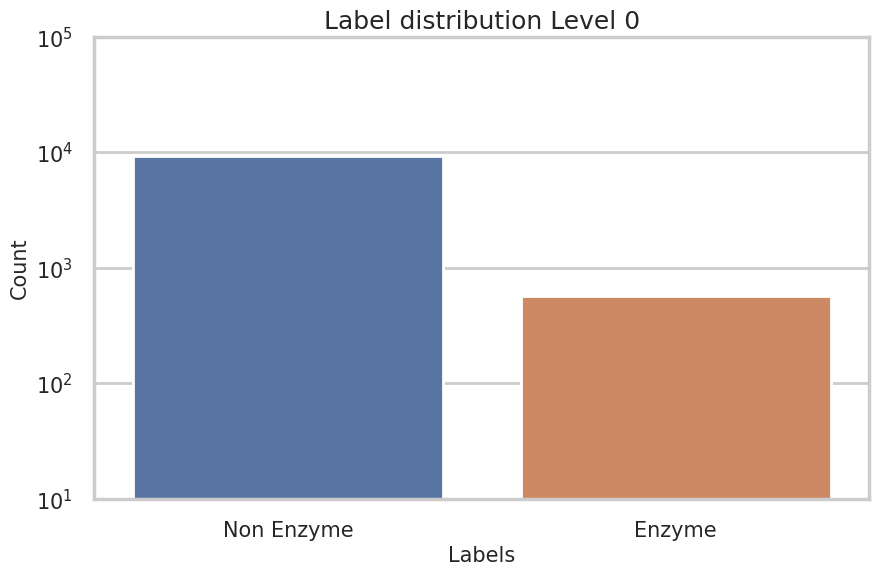

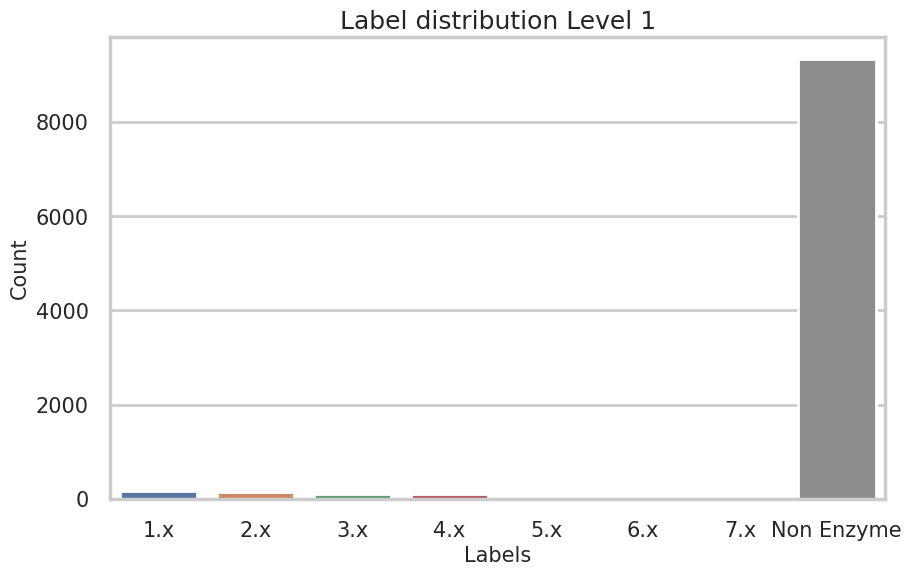

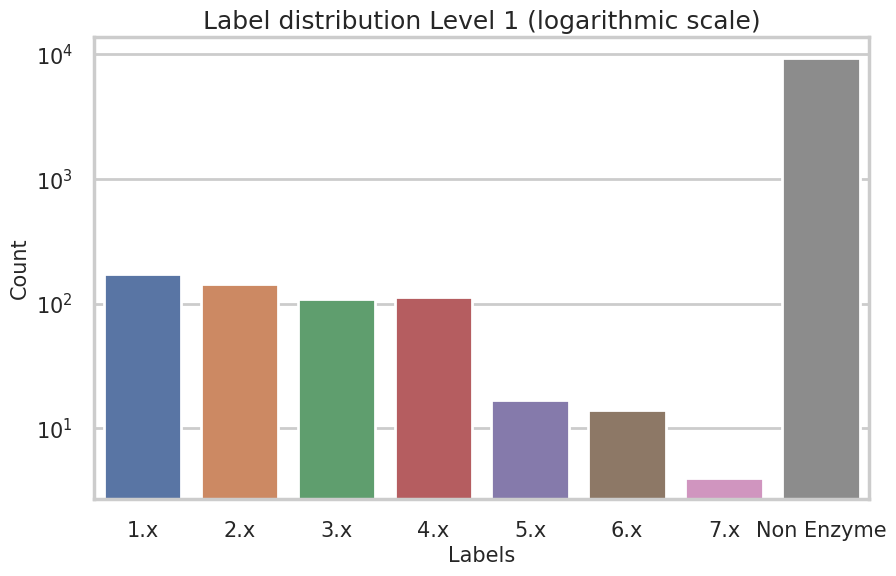

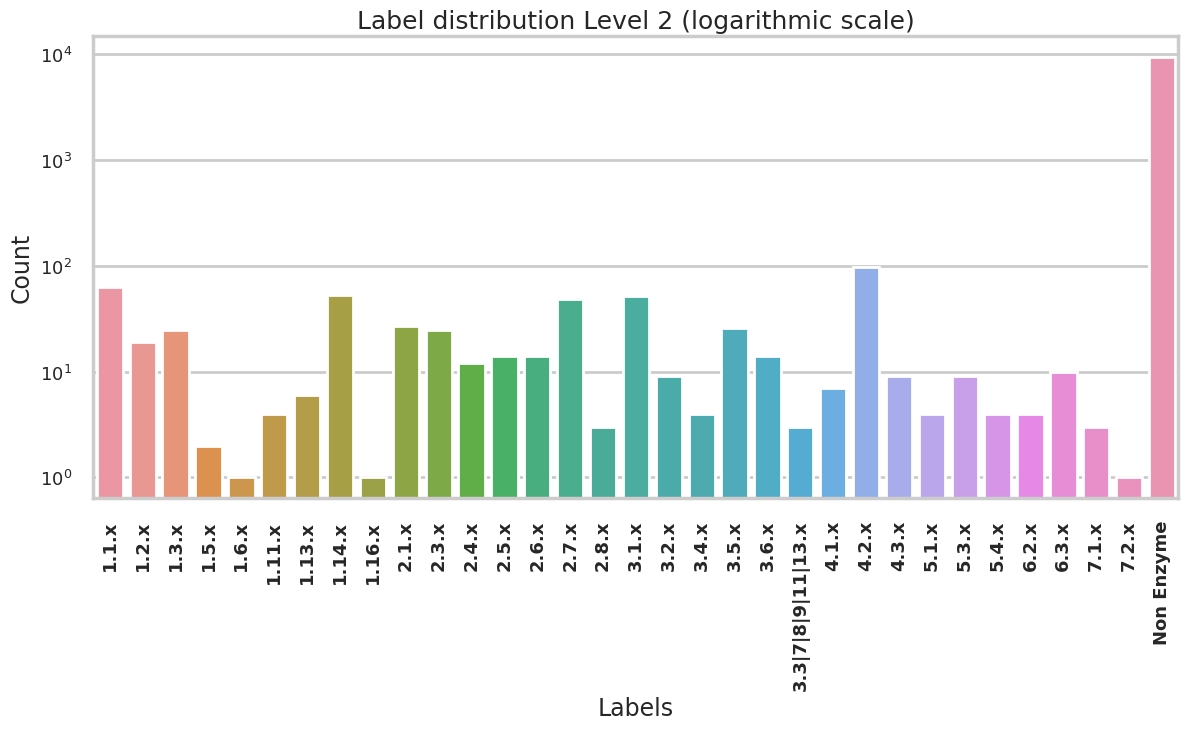

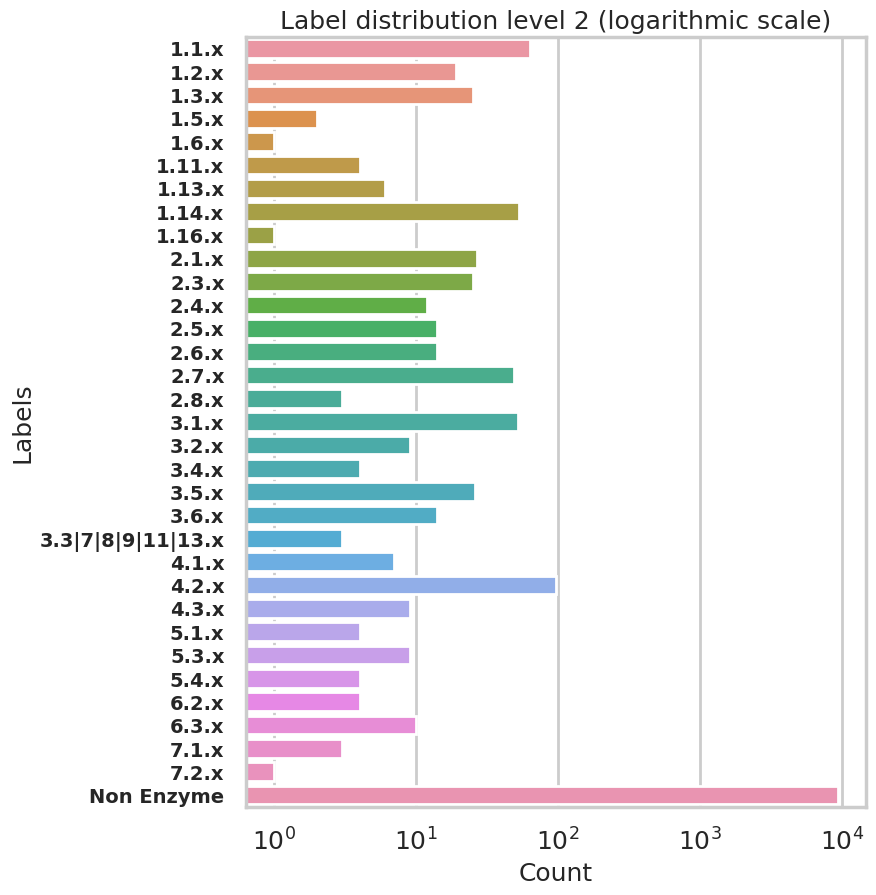

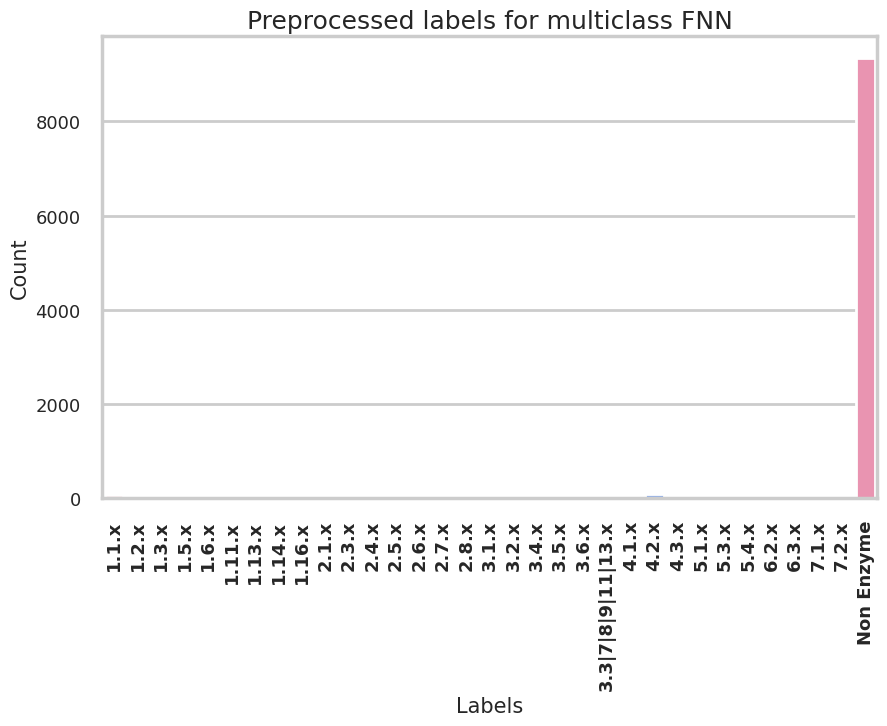



			[ MAKING PREDICTIONS ]

			
310/310 [==============================] - 1s 2ms/step


			[ MAKING BASELINE PREDICTION ]

			


			[ PLOTTING CONFUSION MATRIX ]

			


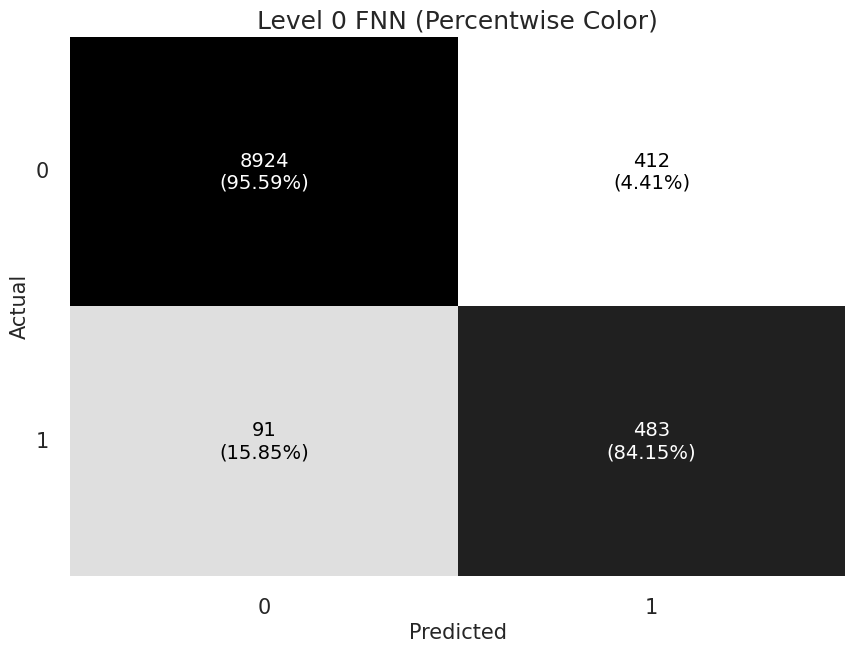

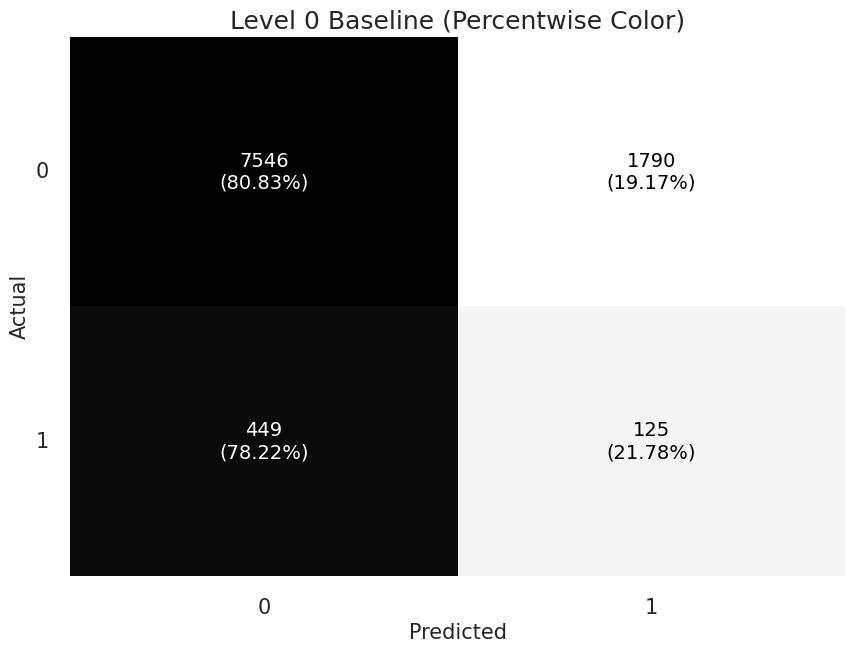

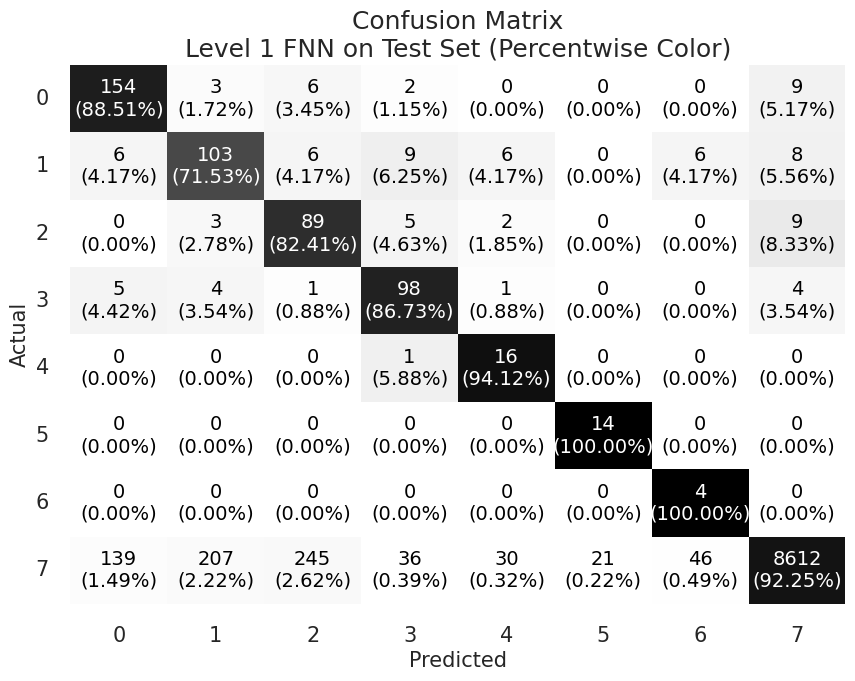

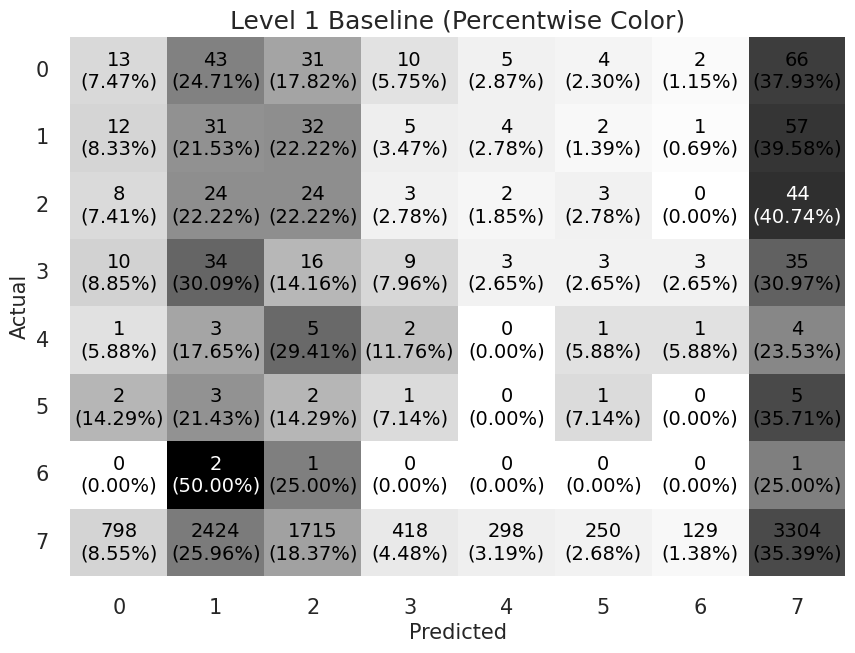

/tmp/ipykernel_4944/108152197.py:227: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percent = (conf_matrix.T / row_sums).T * 100


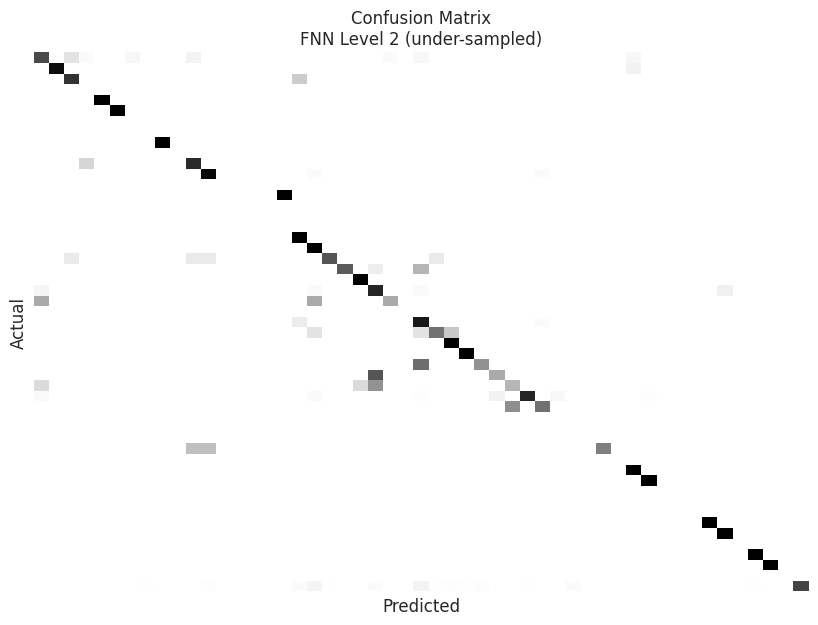

/tmp/ipykernel_4944/108152197.py:239: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percent = (conf_matrix.T / row_sums).T * 100


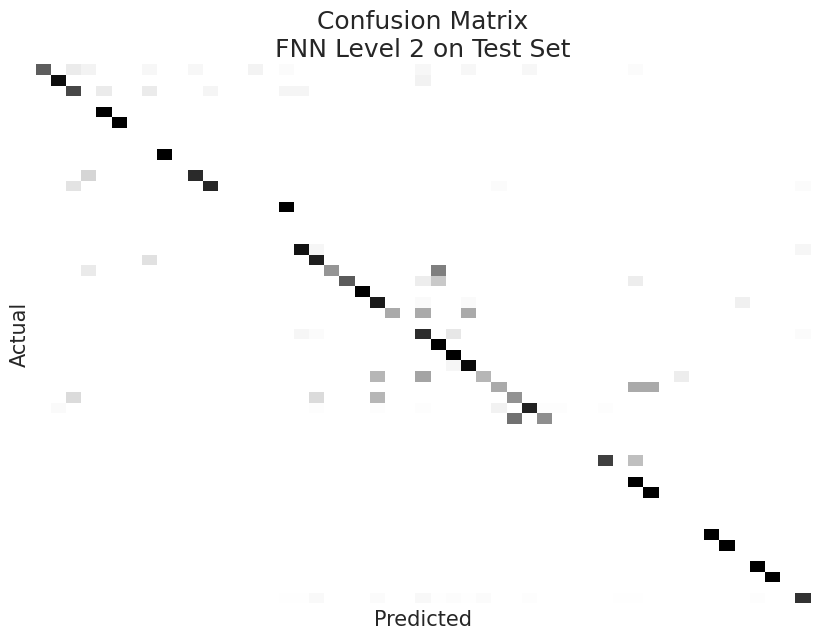

/tmp/ipykernel_4944/108152197.py:252: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percent = (conf_matrix.T / row_sums).T * 100


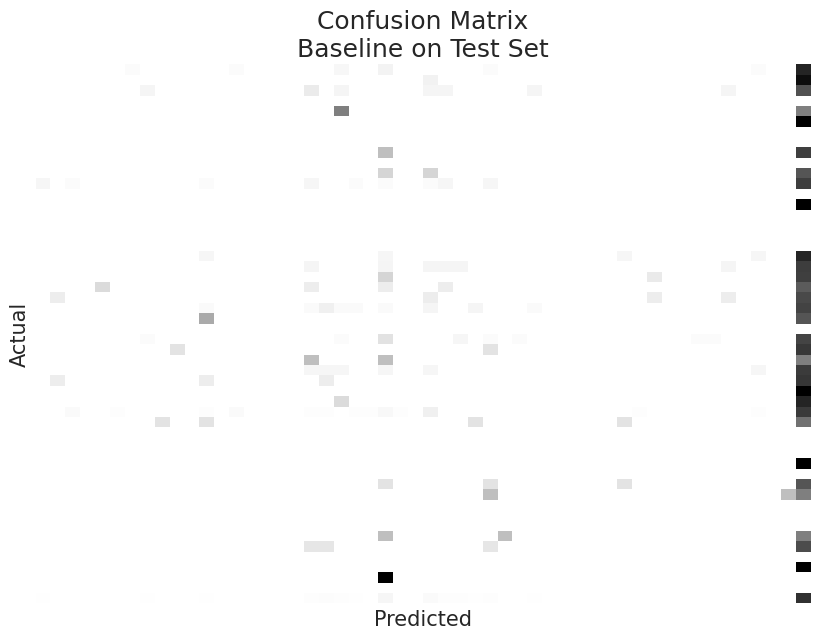



			[ PLOTTING SCORES ]

			
              Model    Metric  Mean Score      SE      CI_0      CI_1
0       FNN Level 0  Micro F1       0.949  0.0022  0.944702  0.953481
1       FNN Level 0       MCC       0.650  0.0140  0.621472  0.676738
0  Baseline Level 0  Micro F1       0.774  0.0042  0.765893  0.782240
1  Baseline Level 0       MCC       0.020  0.0110 -0.005008  0.036151


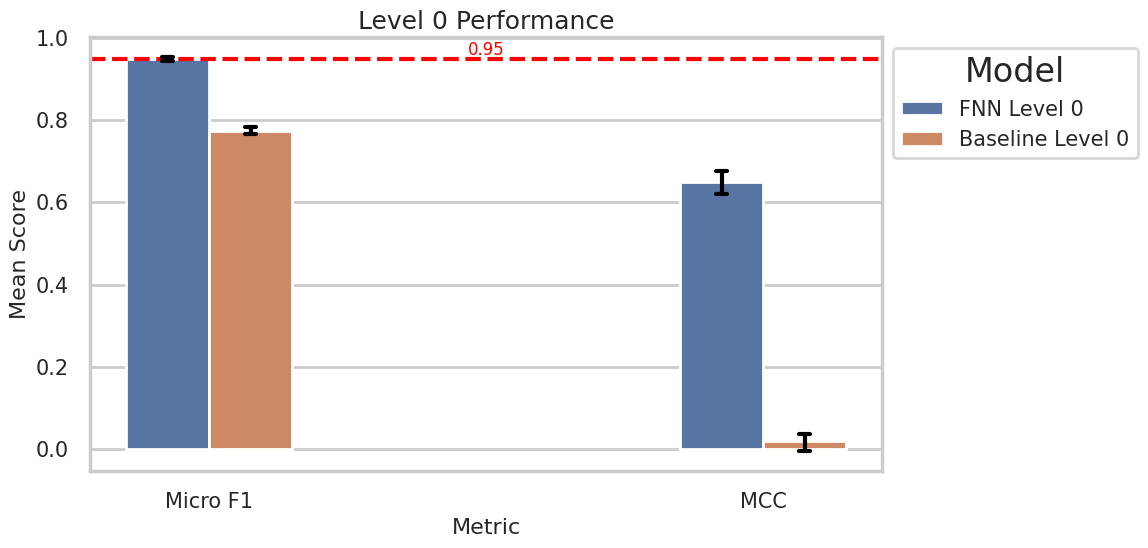

              Model    Metric  Mean Score      SE      CI_0      CI_1
0       FNN Level 1  Micro F1       0.917  0.0028  0.911705  0.922503
1       FNN Level 1       MCC       0.580  0.0120  0.556008  0.602443
0  Baseline Level 1  Micro F1       0.341  0.0047  0.331786  0.350555
1  Baseline Level 1       MCC      -0.003  0.0055 -0.013427  0.007792


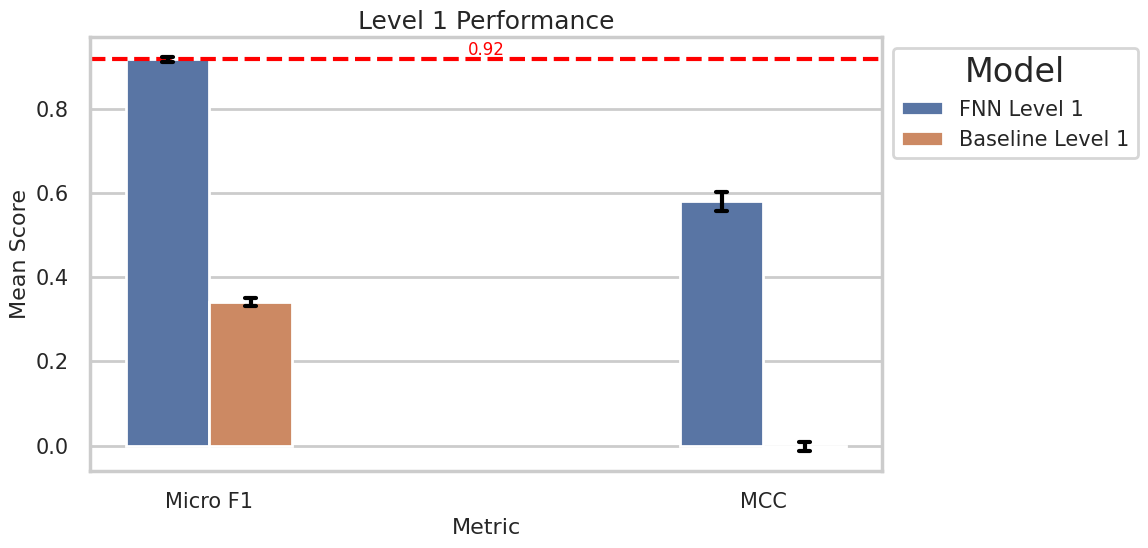

              Model    Metric  Mean Score      SE      CI_0      CI_1
0       FNN Level 2  Micro F1       0.804  0.0040  0.795863  0.811504
1       FNN Level 2       MCC       0.411  0.0090  0.393491  0.428888
0  Baseline Level 2  Micro F1       0.762  0.0043  0.753179  0.769828
1  Baseline Level 2       MCC       0.011  0.0052  0.000647  0.021018


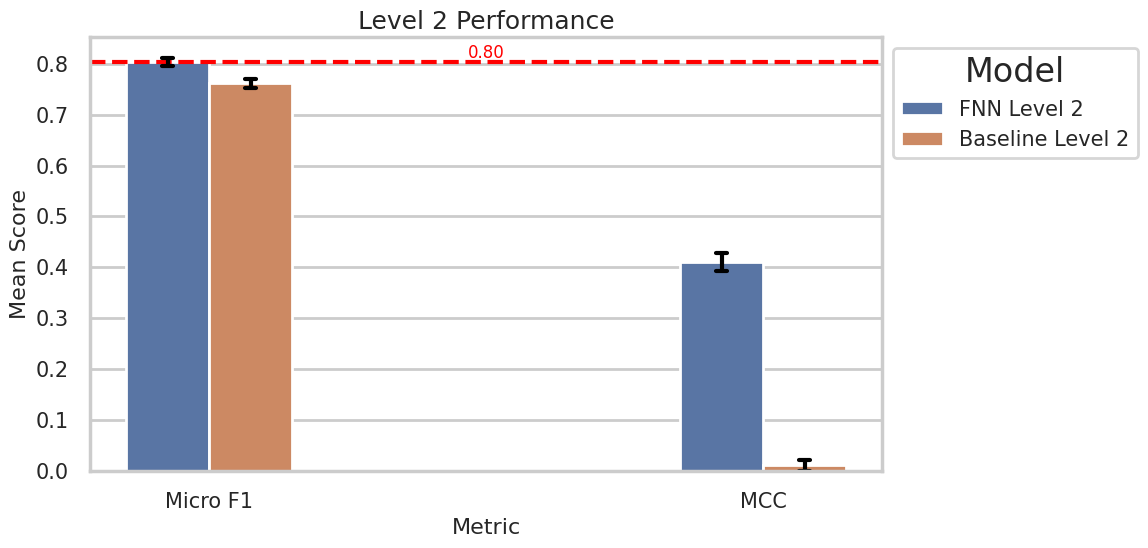

In [55]:
validate_on_test_data_v1(path_to_test_csv=csv_path,
                         path_to_test_esm2=emb_path,
                         path_to_non_ez_esm2=emb_non_ez_path,
                         path_to_non_ez_fasta=fasta_path,
                         path_to_binaryclass_model=bin_class_path,
                         path_to_multiclass_model=mul_class_path)

In [ ]:

emb_path = os.getenv("TEST_ESM2_ENZYMES")
csv_path = os.getenv("TEST_CSV_ENZYMES")

fasta_path = os.getenv("TEST_FASTA_NON_ENZYMES")
emb_non_ez_path = os.getenv("TEST_ESM2_NON_ENZYMES")


In [ ]:

# loead enzymes
X_enzymes, y_enzymes, label_to_ec = load_all_sub_classes(path_to_esm2=emb_path, path_to_enzyme_csv=csv_path, allowed_labels=comp_ec_to_label_non_ez)

# Load non_enzymes
X_non_enzymes, _ = load_non_enz_esm2(non_enzymes_fasta_path=fasta_path,
                                     non_enzymes_esm2_path=emb_non_ez_path)
del _




y_non_enzymes = np.array([51 for _ in range(len(X_non_enzymes))])


X_multiclass_1 = np.vstack((X_enzymes, X_non_enzymes))
y_multiclass_1 = np.hstack((y_enzymes, y_non_enzymes))


# depending on the model, the labels for non enzymes change
y_non_enzymes = np.array([0 for _ in range(len(X_non_enzymes))])
y_non_enzymes_level_one = np.array([7 for _ in range(len(X_non_enzymes))])


# read data and labels for level one (including none enzymes
_, y_level_one = load_ml_data_emb(path_to_esm2=emb_path, path_to_enzyme_csv=csv_path)
y_level_one = np.hstack((y_level_one, y_non_enzymes_level_one))

# X_non_enzymes = X_non_enzymes[:1000] 
# y_non_enzymes = y_non_enzymes[:1000] 

# Combine data
X_binary = np.vstack((X_enzymes, X_non_enzymes))
y_binary = [1 for _ in y_enzymes]
y_binary.extend(y_non_enzymes)
y_binary = np.array(y_binary)


In [25]:
multiclass_model_all_samples = tf.keras.models.load_model("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/1512_all_non_ez_level_2_v2.keras")

level_2_pred_all_samples = np.argmax(multiclass_model_all_samples.predict(X_multiclass_1), axis=-1)


310/310 [==============================] - 1s 2ms/step


In [26]:
print(level_2_pred_all_samples.shape)
print(y_multiclass_1.shape)


(9910,)
(9910,)


# Halogenase.csv only
----

In [64]:
allowed_labels_halogenase = {
"1.11": 8,
"1.14": 11,
"2.5": 21,
"3.13": 31
}

In [74]:

# Load model and test data
multiclass_model_all_samples = tf.keras.models.load_model("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/1512_all_non_ez_level_2_v2.keras")

level_one_model = tf.keras.models.load_model("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/1512_opt_less_nodes_2_weighted.keras")

# binaryclass_model = tf.keras.models.load_model(path_to_binaryclass_model)

# loead enzymes
X_enzymes, y_enzymes, label_to_ec = load_all_sub_classes(path_to_esm2="/home/malte/Desktop/Dataset/Test_Data/halogenase_esm2_3b.h5", path_to_enzyme_csv="/home/malte/Desktop/Dataset/Test_Data/halogenase.csv", allowed_labels=allowed_labels_halogenase)

# Load non_enzymes
# X_non_enzymes, _ = load_non_enz_esm2(
#     non_enzymes_fasta_path="/home/malte/Desktop/Dataset/Test_Data/no_enzyme_test.fasta",
#     non_enzymes_esm2_path="/home/malte/Desktop/Dataset/Test_Data/no_enzyme_test_esm2_3b.h5")
# del _




# y_non_enzymes = np.array([51 for _ in range(len(X_non_enzymes))])
# 
# 
# X_multiclass_1 = np.vstack((X_enzymes, X_non_enzymes))
# y_multiclass_1 = np.hstack((y_enzymes, y_non_enzymes))


# depending on the model, the labels for non enzymes change
# y_non_enzymes = np.array([0 for _ in range(len(X_non_enzymes))])
# y_non_enzymes_level_one = np.array([7 for _ in range(len(X_non_enzymes))])


# read data and labels for level one (including none enzymes
_, y_level_one = load_ml_data_emb(path_to_esm2="/home/malte/Desktop/Dataset/Test_Data/halogenase_esm2_3b.h5", path_to_enzyme_csv="/home/malte/Desktop/Dataset/Test_Data/halogenase.csv")
# y_level_one = np.hstack((y_level_one, y_non_enzymes_level_one))

# X_non_enzymes = X_non_enzymes[:1000] 
# y_non_enzymes = y_non_enzymes[:1000] 

# del y_non_enzymes
# del X_non_enzymes


level_1_pred = np.argmax(level_one_model.predict(X_enzymes), axis=-1)
level_2_pred_all_samples = np.argmax(multiclass_model_all_samples.predict(X_enzymes), axis=-1)


LOG:
 0 Sequences with aa O in /home/malte/Desktop/Dataset/Test_Data/halogenase.csv
LOG:
 0 Sequences with aa U in /home/malte/Desktop/Dataset/Test_Data/halogenase.csv
LOG:
 0 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/Test_Data/halogenase.csv
LOG:
 0 entries will be ignored
LOG:
 Data loaded in: 0.004 min
LOG:
 ESM2 of enzymes: 37
LOG:
 Labels of enzymes: 37
LOG:
 0 Sequences with aa O in /home/malte/Desktop/Dataset/Test_Data/halogenase.csv
LOG:
 0 Sequences with aa U in /home/malte/Desktop/Dataset/Test_Data/halogenase.csv
LOG:
 0 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/Test_Data/halogenase.csv
LOG:
 0 entries will be ignored
Total count:  2
LOG:
 Data loaded in: 0.004 min
LOG:
 ESM2 of enzymes: 37
LOG:
 Labels of enzymes: 37
2/2 [==============================] - 0s 3ms/step


In [78]:
level_2_pred_all_samples

array([40, 27,  8, 11, 11, 31, 26,  8,  8, 11, 11,  8,  2, 11,  2,  2,  2,
       11, 11,  2, 11, 11, 40, 41, 11, 11,  2, 11, 11, 11, 11, 11, 11, 11,
       11, 27, 27])

In [83]:

random_baseline_level_1_pred = random_level_1(y_enzymes)
random_baseline_level_2_pred = random_level_2(y_enzymes)


In [13]:

from metrics_helper_funcs.validation_tools import bootstrap_statistic, round_to_significance

def plot_bootstrapped_score_SOTA(y_trues, y_preds, model_names, plot_title="Performance Metrics with Custom Error Bars by Model"):
    score_df = pd.DataFrame(columns=["Model", "Metric", "Mean Score", "SE", "CI_0", "CI_1", "Problem Level"])
    
    level_dict = {
        # 0: "EC "
        0: "EC X.-.-.-",
        1: "EC X.X.-.-"
    }

    data_to_append = []
    data_row = {"Model": "CLEAN",
                "Metric": "Accuracy",
                "Mean Score": 1,
                "SE": 0, "CI_0": 0.9, "CI_1": 1,
                "Problem Level": "EC X.-.-.-"
                }
    data_to_append.append(data_row)

    data_row = {"Model": "CLEAN",
                "Metric": "Accuracy",
                "Mean Score": 0.9722,
                "SE": 0, "CI_0": 0.97, "CI_1": 0.98,
                "Problem Level": "EC X.X.-.-"
                }
    data_to_append.append(data_row)
    score_df = pd.concat([score_df, pd.DataFrame(data_to_append)])
    
    for i in range(len(y_trues)):
        for j in range(len(level_dict)):

            data_to_append = []

            y_true = y_trues[i]
            y_pred = y_preds[i]
            initial_metric, metric_name = calculate_accuracy(y_true, y_pred)
            mean_metric, se_metric, ci_95 = bootstrap_statistic(y_true=y_true, y_pred=y_pred, statistic_func=calculate_accuracy)
            rounded_mean_metric, rounded_se_metric = round_to_significance(mean_metric, se_metric)
            # Create a dictionary with the data
            data_row = {"Model": model_names[i], 
                        "Metric": metric_name,
                        "Mean Score": rounded_mean_metric,
                        "SE": rounded_se_metric, "CI_0": ci_95[0], "CI_1": ci_95[1],
                        "Problem Level": level_dict[j]
                        }
            data_to_append.append(data_row)

            score_df = pd.concat([score_df, pd.DataFrame(data_to_append)])

    # Set the style and context for the plot
    sns.set()
    sns.set_palette("colorblind")
    sns.set("poster")
    sns.set_style("whitegrid")

    # Create the bar plot with custom error bars and hue="Model"
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x="Problem Level", y="Mean Score", hue="Model", data=score_df, **{'width': 0.3})

    # Customize the plot labels
    ax.set_xlabel("Metric", fontsize=16)
    ax.set_ylabel("Mean Accuracy", fontsize=16)
    ax.set_title(plot_title, fontsize=18)

    # Plot the red line indicating the best performance
    best_performance = score_df['Mean Score'].max()
    plt.axhline(y=best_performance, color='red', linestyle='--')

    # Add the label directly onto the plot
    plt.text(0.5, best_performance, f'{best_performance:.2f}', color='red', ha='center', va='bottom', fontsize=12)



    plt.legend(title="Model", loc="upper left", bbox_to_anchor=(1, 1), fontsize=15)
    print(score_df)

    # Manually add error bars using the calculated bounds
    for i, bar in enumerate(ax.patches):
        metric_data = score_df.iloc[i]
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        lower_bound = metric_data["CI_0"]
        upper_bound = metric_data["CI_1"]

        plt.plot([x, x], [lower_bound, upper_bound], color="black")
        plt.plot([x - 0.01, x + 0.01], [lower_bound, lower_bound], color="black")
        plt.plot([x - 0.01, x + 0.01], [upper_bound, upper_bound], color="black")

    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.tight_layout()


    plt.show()


              Model    Metric  Mean Score     SE      CI_0      CI_1  \
0             CLEAN  Accuracy      1.0000      0  0.900000  1.000000   
1             CLEAN  Accuracy      0.9722      0  0.970000  0.980000   
0       Level 1 FNN  Accuracy      0.7000  0.075  0.540541  0.837838   
0       Level 1 FNN  Accuracy      0.7000  0.074  0.540541  0.837838   
0       Level 2 FNN  Accuracy      0.6200  0.079  0.459459  0.783784   
0       Level 2 FNN  Accuracy      0.6200   0.08  0.459459  0.783784   
0  Baseline Level 1  Accuracy      0.1100  0.051  0.027027  0.216216   
0  Baseline Level 1  Accuracy      0.1100  0.051  0.027027  0.216216   
0   Basline Level 2  Accuracy      0.0000    0.0  0.000000  0.000000   
0   Basline Level 2  Accuracy      0.0000    0.0  0.000000  0.000000   

  Problem Level  
0    EC X.-.-.-  
1    EC X.X.-.-  
0    EC X.-.-.-  
0    EC X.X.-.-  
0    EC X.-.-.-  
0    EC X.X.-.-  
0    EC X.-.-.-  
0    EC X.X.-.-  
0    EC X.-.-.-  
0    EC X.X.-.-  


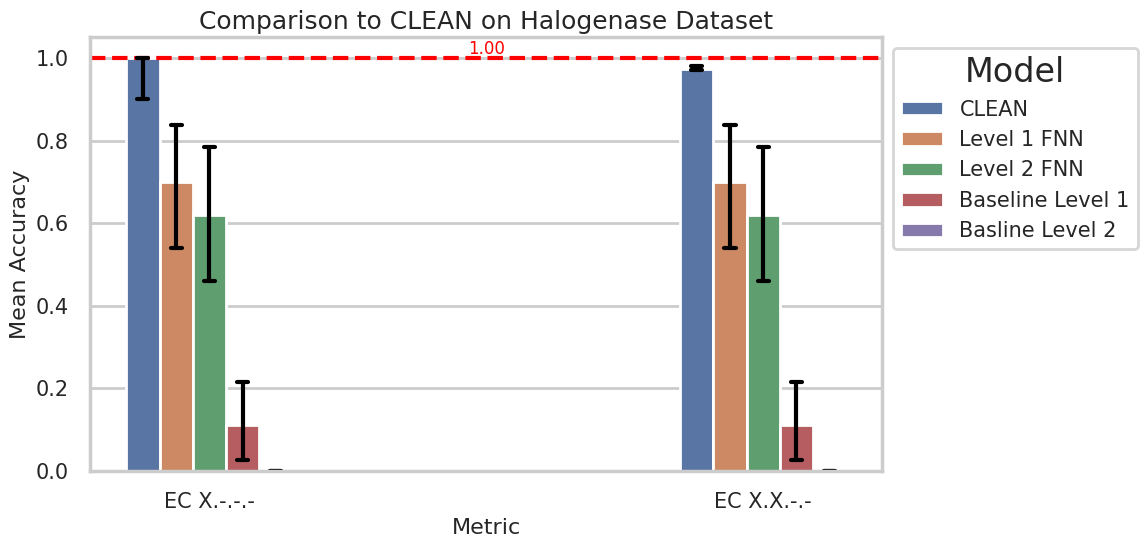

In [87]:
plot_bootstrapped_score_SOTA(y_trues = [y_level_one, y_enzymes, y_level_one, y_enzymes],
                             y_preds= [level_1_pred, level_2_pred_all_samples, random_baseline_level_1_pred, random_baseline_level_2_pred],
                             model_names=["Level 1 FNN", "Level 2 FNN", "Baseline Level 1", "Basline Level 2"],
                             plot_title="Comparison to CLEAN on Halogenase Dataset")

# NEW.csv only
----
JUMP

In [7]:
allowed_labels_NEW = {
"1.1": 0,
"1.13": 10,
"1.14": 11,
"1.16": 13,
"1.2": 1,
"1.3": 2,
"1.5": 4,
"1.6": 5,
"2.1": 18,
"2.3": 19,
"2.4": 20,
"2.5": 21,
"2.7": 23,
"3.1": 26,
"3.2": 27,
"3.4": 28,
"3.5": 29,
"3.6": 30,
"4.1": 32,
"4.2": 33,
"4.3": 34,
"5.1": 38,
"5.3": 40,
"5.4": 41,
"6.2": 45,
"6.3": 46,
"7.1": 48,
"7.2": 49
}

In [8]:

# Load model and test data
multiclass_model_all_samples = tf.keras.models.load_model("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/2nd_ec_class_pred/Models/1512_all_non_ez_level_2_v2.keras")

level_one_model = tf.keras.models.load_model("/home/malte/01_Documents/projects/pbl_binary_classifier/tf_cnn_esm2/enzyme_non_enzyme_models/1512_opt_less_nodes_2_weighted.keras")

# binaryclass_model = tf.keras.models.load_model(path_to_binaryclass_model)

# loead enzymes
X_enzymes, y_enzymes, label_to_ec = load_all_sub_classes(path_to_esm2="/home/malte/Desktop/Dataset/Test_Data/new_esm2_3b.h5", path_to_enzyme_csv="/home/malte/Desktop/Dataset/Test_Data/new.csv", allowed_labels=allowed_labels_NEW)

# Load non_enzymes
# X_non_enzymes, _ = load_non_enz_esm2(
#     non_enzymes_fasta_path="/home/malte/Desktop/Dataset/Test_Data/no_enzyme_test.fasta",
#     non_enzymes_esm2_path="/home/malte/Desktop/Dataset/Test_Data/no_enzyme_test_esm2_3b.h5")
# del _




# y_non_enzymes = np.array([51 for _ in range(len(X_non_enzymes))])
# 
# 
# X_multiclass_1 = np.vstack((X_enzymes, X_non_enzymes))
# y_multiclass_1 = np.hstack((y_enzymes, y_non_enzymes))


# depending on the model, the labels for non enzymes change
# y_non_enzymes = np.array([0 for _ in range(len(X_non_enzymes))])
# y_non_enzymes_level_one = np.array([7 for _ in range(len(X_non_enzymes))])


# read data and labels for level one (including none enzymes
_, y_level_one = load_ml_data_emb(path_to_esm2="/home/malte/Desktop/Dataset/Test_Data/new_esm2_3b.h5", path_to_enzyme_csv="/home/malte/Desktop/Dataset/Test_Data/new.csv")
# y_level_one = np.hstack((y_level_one, y_non_enzymes_level_one))

# X_non_enzymes = X_non_enzymes[:1000] 
# y_non_enzymes = y_non_enzymes[:1000] 

# del y_non_enzymes
# del X_non_enzymes


level_1_pred = np.argmax(level_one_model.predict(X_enzymes), axis=-1)
level_2_pred_all_samples = np.argmax(multiclass_model_all_samples.predict(X_enzymes), axis=-1)

random_baseline_level_1_pred = random_level_1(y_enzymes)
random_baseline_level_2_pred = random_level_2(y_enzymes)


LOG:
 0 Sequences with aa O in /home/malte/Desktop/Dataset/Test_Data/new.csv
LOG:
 0 Sequences with aa U in /home/malte/Desktop/Dataset/Test_Data/new.csv
LOG:
 4 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/Test_Data/new.csv
LOG:
 4 entries will be ignored
LOG:
 Data loaded in: 0.052 min
LOG:
 ESM2 of enzymes: 388
LOG:
 Labels of enzymes: 388
LOG:
 0 Sequences with aa O in /home/malte/Desktop/Dataset/Test_Data/new.csv
LOG:
 0 Sequences with aa U in /home/malte/Desktop/Dataset/Test_Data/new.csv
LOG:
 4 multifunctional enzymes with diff ec main classes in /home/malte/Desktop/Dataset/Test_Data/new.csv
LOG:
 4 entries will be ignored
Total count:  13
LOG:
 Data loaded in: 0.045 min
LOG:
 ESM2 of enzymes: 388
LOG:
 Labels of enzymes: 388
13/13 [==============================] - 0s 2ms/step


              Model       Metric Mean Score      SE      CI_0      CI_1
0       X.-.-.- FNN  Weighted F1        0.9   0.014   0.87472   0.92812
1       X.-.-.- FNN          MCC       0.84   0.021   0.79654  0.877075
0       X.X.-.- FNN  Weighted F1       0.85   0.019  0.813096  0.886035
1       X.X.-.- FNN          MCC       0.83    0.02  0.785301  0.864172
0  Baseline Level 1  Weighted F1       0.18   0.021  0.138457   0.22268
1  Baseline Level 1          MCC       0.01   0.021  -0.02747  0.056366
0  Baseline Level 2  Weighted F1      0.022  0.0097  0.004671  0.043308
1  Baseline Level 2          MCC     -0.001  0.0095 -0.017859  0.018816


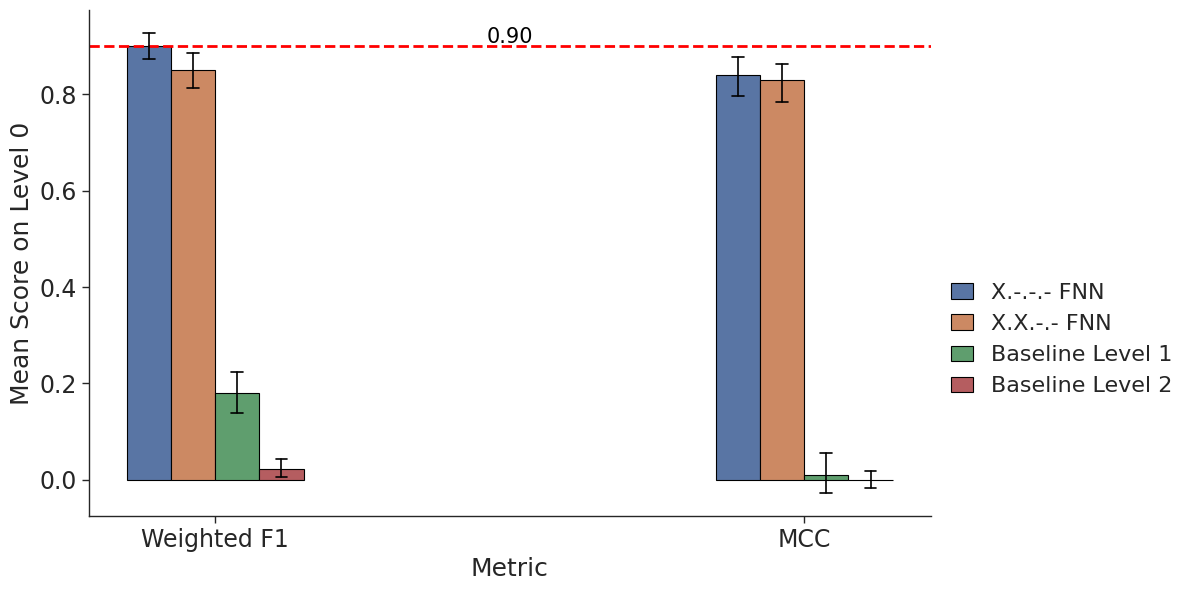

In [10]:
plot_bootstrapped_score(y_trues = [y_level_one, y_enzymes, y_level_one, y_enzymes],
                             y_preds= [level_1_pred, level_2_pred_all_samples, random_baseline_level_1_pred, random_baseline_level_2_pred], scoring_funcs=[calculate_weighted_f1, calculate_mcc_score],
                             model_names=["X.-.-.- FNN", "X.X.-.- FNN", "Baseline Level 1", "Baseline Level 2"])


In [11]:
plot_bootstrapped_score_SOTA(y_trues = [y_level_one, y_enzymes, y_level_one, y_enzymes],
                        y_preds= [level_1_pred, level_2_pred_all_samples, random_baseline_level_1_pred, random_baseline_level_2_pred],
                        model_names=["X.-.-.- FNN", "X.X.-.- FNN", "Baseline Level 1", "Baseline Level 2"],
                        plot_title="Performance on NEW Dataset compared to CLEAN")


NameError: name 'plot_bootstrapped_score_SOTA' is not defined

In [ ]:
conf_matrix = confusion_matrix(y_level_one, level_1_pred)
row_sums = conf_matrix.sum(axis=1)
conf_matrix_percent = (conf_matrix.T / row_sums).T * 100
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="binary", cbar=False)

for text in heatmap.texts:
        text.set_size(12)  # Set the font size of annotations
        text.set_text(text.get_text() + '%')
        
heatmap.set_xticks([])
heatmap.set_yticks([])
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix\n X.-.-.-", fontsize=12)
plt.show()


In [ ]:
conf_matrix = confusion_matrix(y_enzymes, level_2_pred_all_samples)
row_sums = conf_matrix.sum(axis=1)
conf_matrix_percent = (conf_matrix.T / row_sums).T * 100
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="binary", cbar=False)
heatmap.set_xticks([])
heatmap.set_yticks([])
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix\nFNN Level 2", fontsize=12)
plt.show()

conf_matrix = confusion_matrix(y_enzymes, random_baseline_level_2_pred)
row_sums = conf_matrix.sum(axis=1)
conf_matrix_percent = (conf_matrix.T / row_sums).T * 100
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(conf_matrix_percent, annot=False, fmt=".2f", cmap="binary", cbar=False)
heatmap.set_xticks([])
heatmap.set_yticks([])
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix\nBaseline Level 2", fontsize=12)
plt.show()


              Model       Metric Mean Score     SE      CI_0      CI_1
0       FNN Level 1  Weighted F1        0.9  0.014  0.875072  0.928469
1       FNN Level 1          MCC       0.84   0.02  0.796587  0.877339
0  Baseline Level 1  Weighted F1       0.17  0.021  0.128426  0.211004
1  Baseline Level 1          MCC        0.0  0.021  -0.03886  0.043613


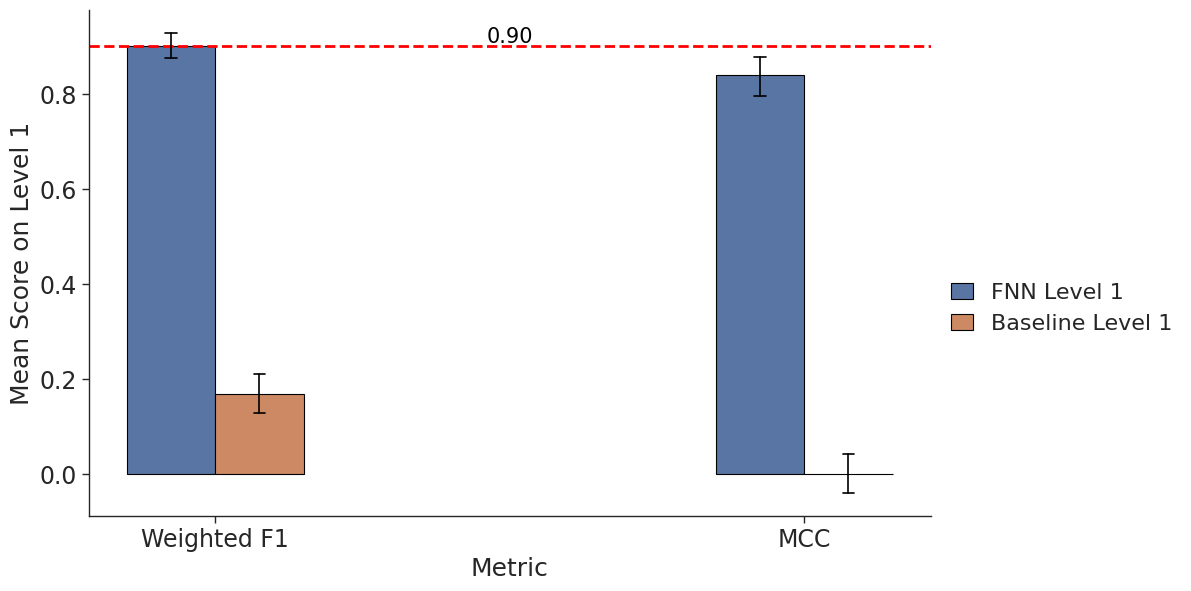

              Model       Metric Mean Score     SE      CI_0      CI_1
0       FNN Level 2  Weighted F1       0.85  0.019  0.811821  0.886963
1       FNN Level 2          MCC       0.83   0.02  0.785006  0.864357
0  Baseline Level 2  Weighted F1       0.03   0.01  0.008288  0.047376
1  Baseline Level 2          MCC       0.01  0.011 -0.014183  0.027537


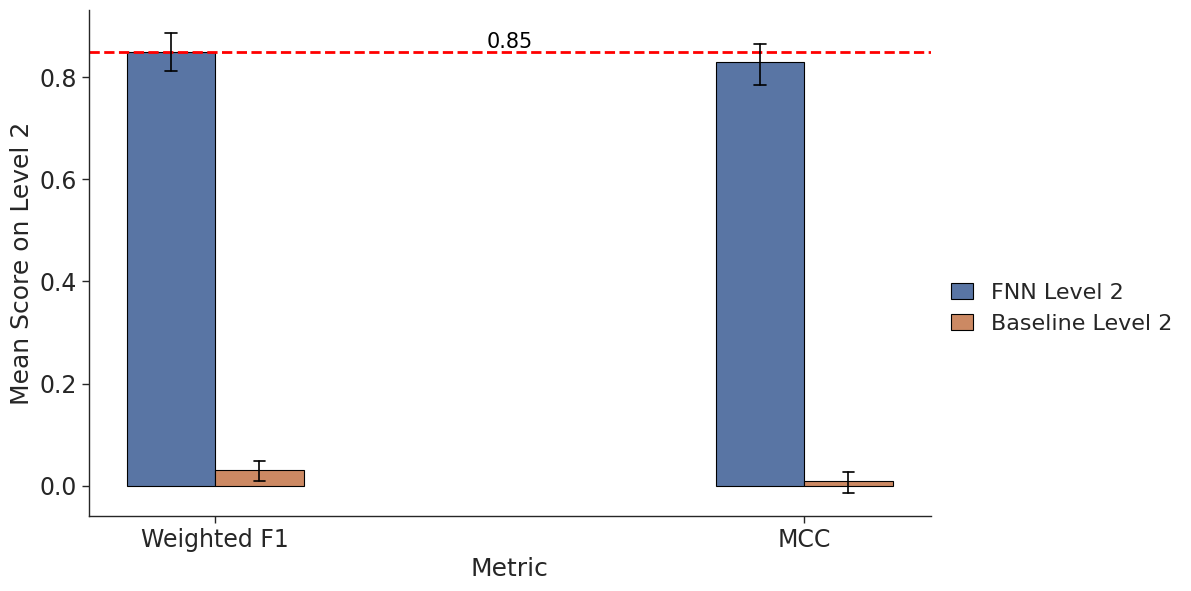

In [9]:
    # level one only
plot_bootstrapped_score(
    y_trues=[y_level_one, y_level_one],
    y_preds=[level_1_pred, random_baseline_level_1_pred],
    scoring_funcs=[calculate_weighted_f1, calculate_mcc_score],
    model_names=["FNN Level 1", "Baseline Level 1"], level=1) 

# level two only
plot_bootstrapped_score(
    y_trues=[y_enzymes, y_enzymes],
    y_preds=[level_2_pred_all_samples,random_baseline_level_2_pred],
    scoring_funcs=[calculate_weighted_f1, calculate_mcc_score],
    model_names=["FNN Level 2", "Baseline Level 2"], level=2)


In [ ]:
sns.set_palette("colorblind")
sns.set("poster")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.set_style("whitegrid")
plt.xticks(fontsize=18, weight='bold')
plt.yticks(fontsize=18)

countplot = sns.countplot(x=y_level_one)
countplot.set_xticklabels(countplot.get_xticklabels())
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["1.-.-.-", "2.-.-.-", "3.-.-.-", "4.-.-.-", "5.-.-.-", "6.-.-.-", "7.-.-.-"])
plt.yscale('log')

# Add labels and title
plt.title("Label distribution level 1 (logarithmic scale)\n'NEW Dataset'", fontsize=18)
plt.xlabel("Labels", fontsize=15)
plt.ylabel("Count", fontsize=15)

# Show the plot
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
# plot with log scale
sns.set_palette("colorblind")
sns.set("poster")
sns.set_style("whitegrid")
plt.xticks(fontsize=18, weight='bold')
plt.yticks(fontsize=18)

countplot = sns.countplot(x=y_enzymes)
countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90)


# Set logarithmic scale on y-axis
plt.yscale('log')

x = list(allowed_labels_NEW.values())
x.sort()

y = list(allowed_labels_NEW.keys())

y = [f'{label}.-.-' for label in y]

xticks = range(0,28)
plt.xticks(xticks, y)
# Add labels and title
plt.title("Label distribution level 2 (logarithmic scale)\n'NEW' Dataset", fontsize=18)
plt.xlabel("Labels", fontsize=18)
plt.ylabel("Count", fontsize=18)

plt.show()


In [ ]:
x = list(allowed_labels_NEW.values())
x.sort()
print(x)

In [ ]:
y = list(allowed_labels_NEW.keys())

In [ ]:
y = [f'{label}.-.-' for label in y]

In [44]:
y

28

In [7]:
# knn esm jan
with open("/home/malte/01_Documents/Temp/results_jan/knn_esm2_y_test.txt") as file:
    y_true_jan_knn_esm = np.array([int(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_jan/knn_esm2_y_pred.txt") as file:
    y_pred_jan_knn_esm = np.array([int(line.strip()) for line in file])

# knn prot jan
with open("/home/malte/01_Documents/Temp/results_jan/knn_prott5_y_test.txt") as file:
    y_true_jan_knn_prot = np.array([int(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_jan/knn_prott5_y_pred.txt") as file:
    y_pred_jan_knn_prot = np.array([int(line.strip()) for line in file])



with open("/home/malte/01_Documents/Temp/results_truc/y_test.csv") as file:
    y_true_truc = np.array([int(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_truc/y_pred.csv") as file:
    y_pred_truc = np.array([int(line.strip()) for line in file])

with open("/home/malte/01_Documents/Temp/results_malte/y_test.txt") as file:
    y_true_gzip = np.array([int(line.strip()) for line in file])
with open("/home/malte/01_Documents/Temp/results_malte/y_pred.txt") as file:
    y_pred_gzip= np.array([int(line.strip()) for line in file])



In [8]:

y_trues = [y_true_truc, y_true_jan_knn_esm, y_true_jan_knn_prot, y_true_gzip]
y_preds = [y_pred_truc, y_pred_jan_knn_esm, y_pred_jan_knn_prot, y_pred_gzip]

# y_trues = [y_true_jan_knn_prot]
# y_preds = [y_pred_jan_knn_prot]
for ar in y_trues:
    print(len(ar))
for ar in y_preds:
    print(len(ar))


10268
4233
4232
9728
10268
4233
4232
9728


In [9]:

def plot_bootstrapped_score_binary(y_trues, y_preds, scoring_funcs, model_names, plot_title="Performance Metrics with Custom Error Bars by Model"):
    score_df = pd.DataFrame(columns=["Model", "Metric", "Mean Score", "SE", "CI_0", "CI_1"])

    for i in range(len(y_trues)):

        data_to_append = []

        for func in scoring_funcs:
            y_true = y_trues[i]
            y_pred = y_preds[i]
            initial_metric, metric_name = func(y_true, y_pred)
            mean_metric, se_metric, ci_95 = bootstrap_statistic(y_true=y_true, y_pred=y_pred, statistic_func=func)
            rounded_mean_metric, rounded_se_metric = round_to_significance(mean_metric, se_metric)
            # Create a dictionary with the data
            data_row = {"Model": model_names[i], "Metric": metric_name, "Mean Score": rounded_mean_metric,
                        "SE": rounded_se_metric, "CI_0": ci_95[0],
                        "CI_1": ci_95[1]}
            data_to_append.append(data_row)

        score_df = pd.concat([score_df, pd.DataFrame(data_to_append)])

    # Set the style and context for the plot
    sns.set()
    sns.set_palette("colorblind")
    sns.set("paper")
    sns.set_style("ticks")

    # Create the bar plot with custom error bars and hue="Model"
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x="Metric", y="Mean Score", hue="Model", data=score_df,edgecolor='black',**{'width': 0.3} )

    # Customize the plot labels
    ax.set_xlabel("Metric", fontsize=18)
    ax.set_ylabel("Mean Score on Level 0", fontsize=18)
    ax.set_title("")

    # ax.grid(False)
    
    # add line with best score
    # best_performance = score_df['Mean Score'].max()
    # plt.axhline(y=best_performance, color='red', linestyle='--', linewidth=2)
    # plt.text(0.5, best_performance, f'{best_performance:.2f}', color='black', ha='center', va='bottom', fontsize=15)

    plt.legend(title="", loc="upper left", bbox_to_anchor=(1, 0.5), fontsize=16, frameon=False, handlelength=1)


    # Manually add error bars using the calculated bounds
    for i, bar in enumerate(ax.patches):
        metric_data = score_df.iloc[i]
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()
        lower_bound = metric_data["CI_0"]
        upper_bound = metric_data["CI_1"]

        plt.plot([x, x], [lower_bound, upper_bound], color="black")
        plt.plot([x - 0.01, x + 0.01], [lower_bound, lower_bound], color="black")
        plt.plot([x - 0.01, x + 0.01], [upper_bound, upper_bound], color="black")
    
    # Add text on top of bars
    for i, bar in enumerate(ax.patches):
        metric_data = score_df.iloc[i]
        x = bar.get_x() + bar.get_width() / 2
        y = bar.get_height()

        plt.text(x, y + 0.05, f'{metric_data["Mean Score"]:.2f}', ha='center', va='bottom', rotation=90, fontsize=12)

    sns.despine()
    
    ax.tick_params(axis='both', which='major', labelsize=17)
    
    plt.tight_layout()


    print(score_df)
    plt.show()


           Model       Metric Mean Score      SE      CI_0      CI_1
0  Random Forest          MCC       0.74   0.015  0.709848  0.770124
1  Random Forest  Weighted F1      0.978  0.0013   0.97537  0.980481
0      kNN  esm2          MCC       0.69    0.01  0.668157  0.708082
1      kNN  esm2  Weighted F1      0.834  0.0056  0.823208  0.845226
0     kNN  proT5          MCC      0.728  0.0098  0.708169  0.746928
1     kNN  proT5  Weighted F1      0.858  0.0052  0.847685   0.86836
0       kNN  ncd          MCC      0.177  0.0074  0.162175    0.1917
1       kNN  ncd  Weighted F1      0.677  0.0043  0.667925  0.684903


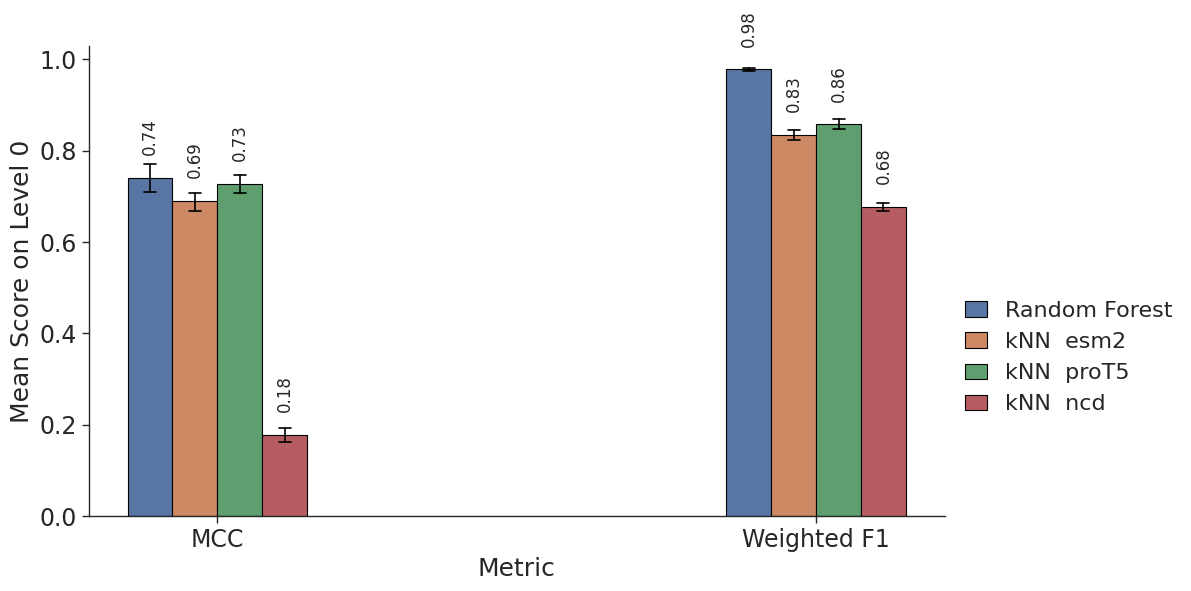

In [10]:
scoring_funcs = [calculate_mcc_score, calculate_weighted_f1]
plot_bootstrapped_score_binary(y_trues, 
                               y_preds, 
                               scoring_funcs=scoring_funcs,
                               model_names=["Random Forest", "kNN  esm2", "kNN  proT5", "kNN  ncd"])